In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import logging
import lstm #
from lstm import ModelHyperparameters, TrainingConfig # Import the dataclasses
from data_prep import (
    DataInputConfig,
    TransformationConfig,
    FeatureEngineeringConfig,
    ScalingConfig,
    SequenceConfig,
    prepare_weather_data
)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('solar_weather.csv')
df

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196771,2022-08-31 16:45:00,118,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,0.95,3,16,8
196772,2022-08-31 17:00:00,82,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,0.96,3,17,8
196773,2022-08-31 17:15:00,51,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,0.98,3,17,8
196774,2022-08-31 17:30:00,24,2.1,18.5,1023,61,4.2,0.0,0.0,60,1,825,825,1.00,3,17,8


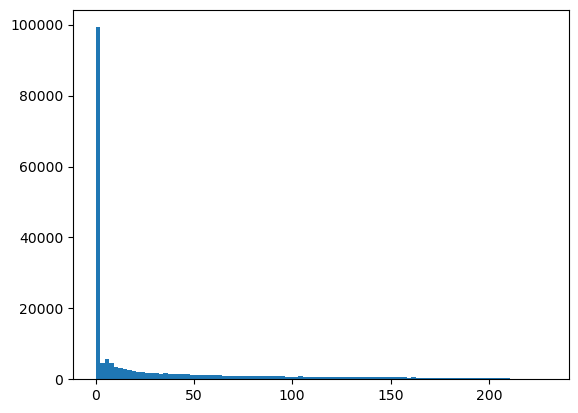

In [3]:
rad = df['GHI']

plt.hist(rad, bins=100)
plt.show()




## LSTM NN

In [4]:
target_col_original = 'GHI' 

input_cfg = DataInputConfig(
    target_col_original_name=target_col_original
)

transform_cfg = TransformationConfig(
    use_log_transform=False, 
    use_power_transform=True, 
    use_piecewise_transform_target=False, 
    min_target_threshold_initial=None, 
    clip_original_target_before_power_transform=False, 
    original_target_clip_lower_percentile=10.0, 
    original_target_clip_upper_percentile=90.0, 
    min_radiation_floor_before_power_transform=0.0, 
    min_radiation_for_log=0.001, 
    clip_log_transformed_target=True, 
    log_clip_lower_percentile=1.0, 
    log_clip_upper_percentile=99.0 
)

feature_cfg = FeatureEngineeringConfig(
    use_solar_elevation_proxy=True, 
    feature_selection_mode='basic' 
   
)

scaling_cfg = ScalingConfig(
    standardize_features=False 
)

sequence_cfg = SequenceConfig(
    window_size=24, 
    test_size=0.15, 
    val_size_from_train_val=0.25 / (1.0 - 0.15) if (1.0 - 0.15) > 0 else 0.25
)


In [5]:
try:
    X_train, X_val, X_test, y_train, y_val, y_test, \
    scalers, feature_cols, full_transform_details = prepare_weather_data(
        df_input=df,
        input_cfg=input_cfg,
        transform_cfg=transform_cfg,
        feature_cfg=feature_cfg,
        scaling_cfg=scaling_cfg,
        sequence_cfg=sequence_cfg
    )

    logging.info("Data preparation successful using v2.")
    logging.info(f"X_train shape: {X_train.shape}, feature_cols: {feature_cols}")
    logging.info(f"Full transform details: {full_transform_details}")

except Exception as e:
    logging.error(f"Error during data preparation: {e}", exc_info=True)

2025-05-28 15:12:34,450 - INFO - Starting weather data preparation pipeline v2.
2025-05-28 15:12:34,470 - INFO - Applied column renames: {'GHI': 'Radiation', 'temp': 'Temperature', 'pressure': 'Pressure', 'humidity': 'Humidity', 'wind_speed': 'WindSpeed', 'clouds_all': 'Cloudcover', 'rain_1h': 'Rain', 'snow_1h': 'Snow', 'weather_type': 'WeatherType', 'Time': 'Timestamp', 'hour': 'hour', 'month': 'month', 'dayLength': 'dayLength', 'isSun': 'isSun', 'SunlightTime/daylength': 'SunlightTime/daylength'}
2025-05-28 15:12:34,508 - INFO - Sorted DataFrame by 'Timestamp'.
2025-05-28 15:12:34,643 - INFO - Engineered 'SolarElevation' feature.
2025-05-28 15:12:34,655 - INFO - Applying Yeo-Johnson Power Transform to 'Radiation'.
2025-05-28 15:12:34,736 - INFO - Engineered 'Radiation_is_low' feature with threshold -0.0000 (based on 'Radiation_yj').
2025-05-28 15:12:34,737 - INFO - Including low target indicator 'Radiation_is_low' in features.
2025-05-28 15:12:34,737 - INFO - Final selected features 

In [6]:
import optuna
import torch
import itertools
from sklearn.metrics import r2_score
device = torch.device('cpu')
def objective(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    clip_grad_norm = trial.suggest_categorical('clip_grad_norm', [1.0, 1.5])
    value_multiplier = trial.suggest_categorical('value_multiplier', [0.1, 0.15, 0.2])
    scheduler_type = trial.suggest_categorical('scheduler_type', ['plateau', 'cosine'])
    loss_type = trial.suggest_categorical('loss_type', ['mse', 'value_aware'])
    mse_weight = trial.suggest_categorical('mse_weight', [0.5, 0.7, 0.9])
    mape_weight = trial.suggest_categorical('mape_weight', [0.5, 0.3, 0.1])
    # Create model with trial parameters
    model = lstm.WeatherLSTM(
        input_dim=len(feature_cols),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout_prob=dropout_prob
    )
    
    # Train model
    model.fit(
        X_train, y_train, X_val, y_val,
        epochs=10,  # Just 5 epochs for initial screening
        batch_size=32,
        learning_rate=learning_rate,  # Use the suggested learning rate
        scheduler_type=scheduler_type,
        loss_type=loss_type,
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=value_multiplier,  # Use the suggested value multiplier
        clip_grad_norm=clip_grad_norm  # Use the suggested clip gradient norm
    )
    
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_val, dtype=torch.float32).to(device))
        predictions = predictions.cpu().numpy()
    
    # Calculate metrics
    r2 = r2_score(y_val, predictions)
    print(f"Trial {trial.number}: hidden_dim={hidden_dim}, num_layers={num_layers}, "
          f"dropout_prob={dropout_prob}, learning_rate={learning_rate:.6f}, "
          f"clip_grad_norm={clip_grad_norm}, value_multiplier={value_multiplier}, R²={r2:.4f}")
    
    return r2  # Return metric to maximize



# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1)

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best value (R²): {study.best_value:.4f}")

[I 2025-05-28 15:12:59,608] A new study created in memory with name: no-name-969061ca-8802-4200-97d7-084aa21020d5
[W 2025-05-28 15:12:59,615] Trial 0 failed with parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.3, 'learning_rate': 0.00010376989756258857, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.5} because of the following error: TypeError("__init__() got an unexpected keyword argument 'input_dim'").
Traceback (most recent call last):
  File "/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/4q/4w3g7t5n0td3xk6v5zqfpp2w0000gn/T/ipykernel_44444/86243324.py", line 19, in objective
    model = lstm.WeatherLSTM(
TypeError: __init__() got an unexpected keyword argument 'input_dim'
[W 2025-05-28 15:12:59,616] Trial 1 failed with parameters: {'hidden_dim': 

TypeError: __init__() got an unexpected keyword argument 'input_dim'

In [8]:
# Your existing parameter definitions (or use your Optuna best_params)
input_dim = len(feature_cols)  # Number of features
hidden_dim = 256
num_layers = 1
output_dim = 1  # Dimension of output
dropout_prob = 0.3

# Create ModelHyperparameters instance
model_params = ModelHyperparameters(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout_prob=dropout_prob
)

# Training related parameters from your fit call
learning_rate_val = 0.00015
epochs_val = 10
batch_size_val = 32
patience_val = 30
scheduler_type_val = "cosine"
weight_decay_val = 0.0 # Corrected your comment, was 0,#0,
clip_grad_norm_val = 1.0
loss_type_val = 'mse'
mse_weight_val = 0.7
mape_weight_val = 0.3 
value_multiplier_val = 0.1

# Create TrainingConfig instance
train_cfg = TrainingConfig(
    epochs=epochs_val,
    batch_size=batch_size_val,
    learning_rate=learning_rate_val,
    patience=patience_val,
    scheduler_type=scheduler_type_val,
    weight_decay=weight_decay_val,
    clip_grad_norm=clip_grad_norm_val,
    loss_type=loss_type_val,
    mse_weight=mse_weight_val,
    mape_weight=mape_weight_val,
    value_multiplier=value_multiplier_val,
    T_max_cosine=10
    # factor and min_lr for ReduceLROnPlateau will use defaults if not specified
    # T_max_cosine for CosineAnnealingLR will default to epochs if None
)

In [9]:
# Initialize model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu') # More robust device selection

# Use the model_params dataclass for instantiation
model = lstm.WeatherLSTM(model_params=model_params).to(device)


In [10]:

model.transform_info = full_transform_details

# Train the model using the train_cfg dataclass
model.fit(
    X_train, y_train, X_val, y_val,
    train_config=train_cfg, # Pass the TrainingConfig instance
    device=device
)


2025-05-28 15:13:57,566 - INFO - LSTM Training started. Device: mps, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.00015, patience=30, factor=0.5, min_lr=1e-06, weight_decay=0.0, clip_grad_norm=1.0, scheduler_type='cosine', T_max_cosine=10, loss_type='mse', mse_weight=0.7, mape_weight=0.3, value_multiplier=0.1)
2025-05-28 15:14:25,927 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.1359 - ValLoss: 0.0546 | Scaled Metrics: ValRMSE: 0.2337, ValR²: 0.9462, ValCappedMAPE: 16.00%, ValMAE: 0.1197
2025-05-28 15:14:51,500 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0523 - ValLoss: 0.0287 | Scaled Metrics: ValRMSE: 0.1694, ValR²: 0.9718, ValCappedMAPE: 11.72%, ValMAE: 0.0783
2025-05-28 15:15:17,752 - INFO - LSTM Epoch 3/10 - TrainLoss: 0.0361 - ValLoss: 0.0185 | Scaled Metrics: ValRMSE: 0.1361, ValR²: 0.9818, ValCappedMAPE: 11.16%, ValMAE: 0.0693
2025-05-28 15:15:42,808 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0289 - ValLoss: 0.0159 | Scaled Metrics: ValRMSE: 0.1261, ValR²: 0.984

WeatherLSTM(
  (lstm): LSTM(10, 256, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [11]:
model.save('weather_lstm_model.pt')

2025-05-28 15:18:12,610 - INFO - LSTM Model saved to weather_lstm_model.pt


In [12]:
model.load('weather_lstm_model.pt')

2025-05-28 15:10:53,863 - INFO - LSTM Model loaded from weather_lstm_model.pt with weights_only=False.


WeatherLSTM(
  (lstm): LSTM(10, 256, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

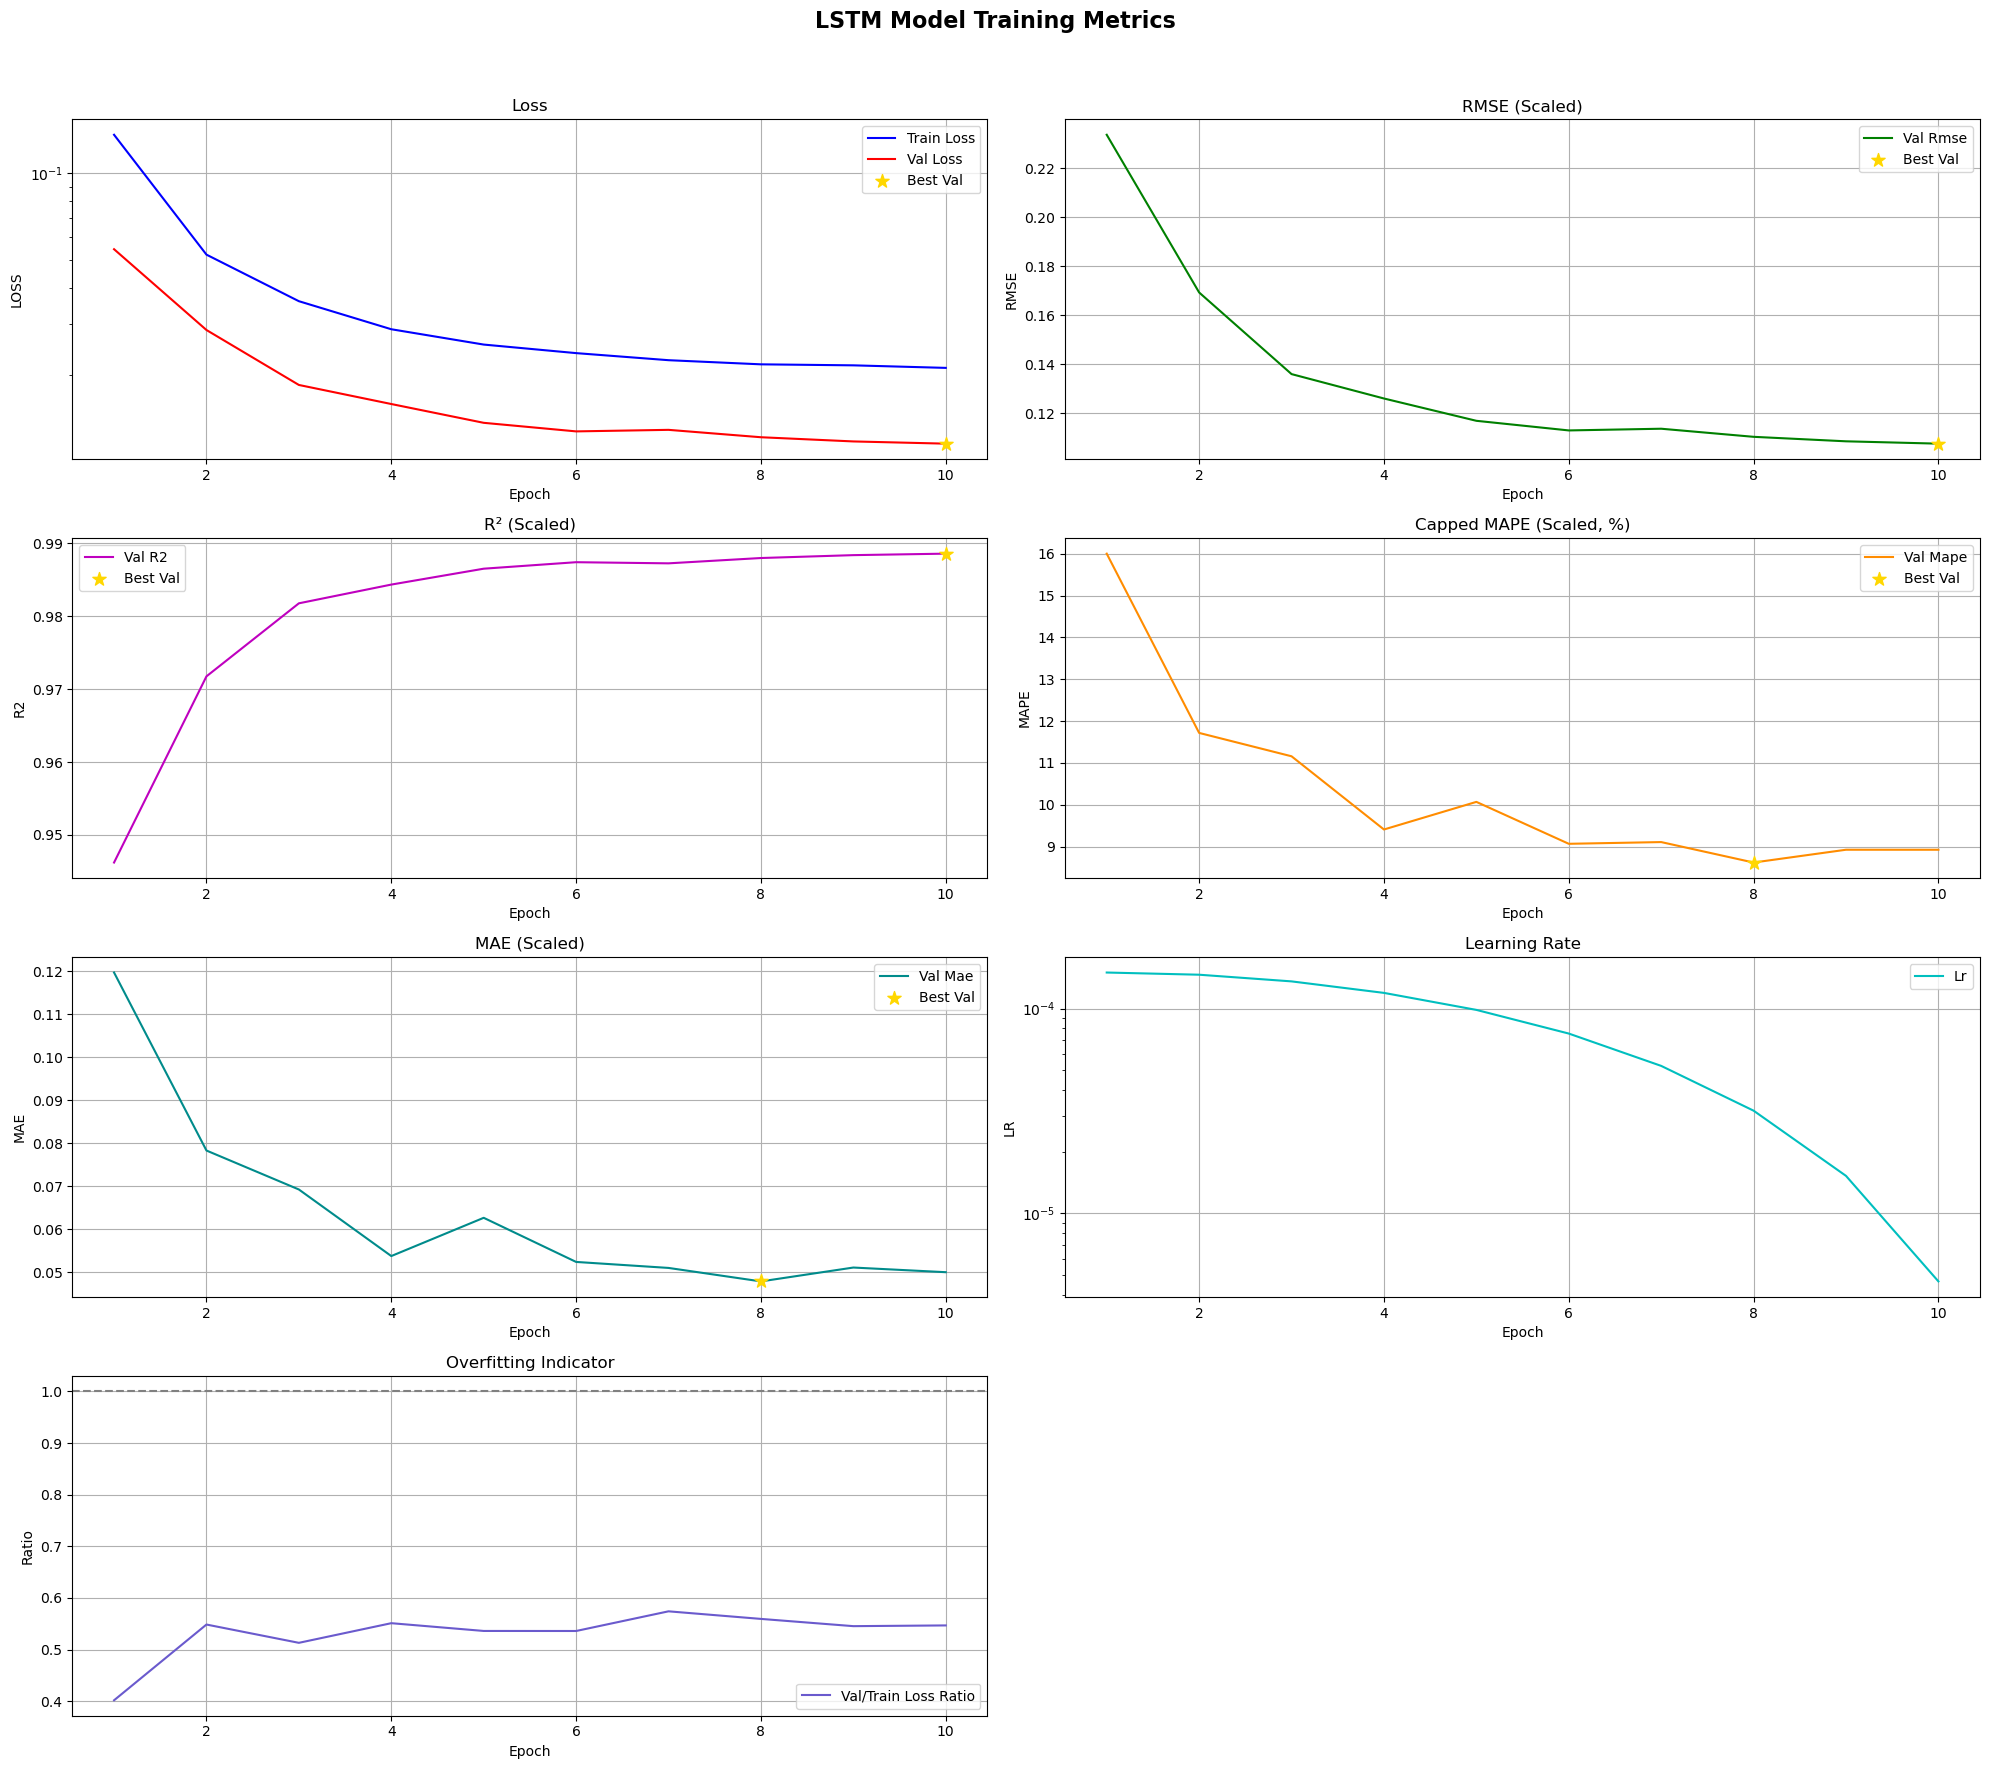

In [19]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()
model.transform_info = full_transform_details  # Store the whole transform_info object

In [13]:
logging.info("Evaluating model on test data...")
try:
    # Evaluate on test data using the refactored method signature
    scaled_preds, scaled_actuals, original_preds, original_actuals, metrics_dict = model.evaluate(
        X_test_data=X_test,
        y_test_data=y_test,
        device=device,  # Pass the device
        target_scaler_object=scalers.get(full_transform_details.get('target_scaler_name')), # Get the specific target scaler
        transform_info_dict=full_transform_details, # This should be the output from data_prep
        scalers_dict=scalers  # Pass the whole scalers dictionary
    )

    # Access metrics directly from the returned dictionary
    if original_preds is not None and original_actuals is not None:
        logging.info(f"Test RMSE (original scale from metrics_dict): {metrics_dict.get('rmse', 'N/A'):.4f}")
        logging.info(f"Test MAE (original scale from metrics_dict): {metrics_dict.get('mae', 'N/A'):.4f}")
        logging.info(f"Test Capped MAPE (original scale from metrics_dict): {metrics_dict.get('mape_capped', 'N/A'):.2f}%")
        logging.info(f"Test R² (original scale from metrics_dict): {metrics_dict.get('r2', 'N/A'):.4f}")
    else:
        logging.warning("Original scale predictions/actuals were not generated, cannot report original scale metrics here.")

    logging.info(f"All scaled metrics: "
                 f"RMSE={metrics_dict.get('scaled_rmse', 'N/A'):.4f}, "
                 f"MAE={metrics_dict.get('scaled_mae', 'N/A'):.4f}, "
                 f"Capped MAPE={metrics_dict.get('scaled_mape_capped', 'N/A'):.2f}% "
                 f"R²={metrics_dict.get('scaled_r2', 'N/A'):.4f}")

except Exception as e:
    logging.error(f"Error during model evaluation: {e}", exc_info=True)




2025-05-28 15:18:13,320 - INFO - Evaluating model on test data...
2025-05-28 15:18:15,967 - INFO - 
--- LSTM Scaled Metrics ---
2025-05-28 15:18:16,226 - INFO - RMSE (scaled): 0.1072, R² (scaled): 0.9887, MAE (scaled): 0.0487, Capped MAPE (scaled): 8.99%
2025-05-28 15:18:16,232 - INFO - 
--- LSTM Original Scale Metrics ---
2025-05-28 15:18:16,305 - INFO - RMSE (original): 0.1434, R² (original): 0.9887, MAE (original): 0.0652, Capped MAPE (original): 52.17%
2025-05-28 15:18:16,312 - INFO - Test RMSE (original scale from metrics_dict): 0.1434
2025-05-28 15:18:16,313 - INFO - Test MAE (original scale from metrics_dict): 0.0652
2025-05-28 15:18:16,313 - INFO - Test Capped MAPE (original scale from metrics_dict): 52.17%
2025-05-28 15:18:16,313 - INFO - Test R² (original scale from metrics_dict): 0.9887
2025-05-28 15:18:16,313 - INFO - All scaled metrics: RMSE=0.1072, MAE=0.0487, Capped MAPE=8.99% R²=0.9887


2025-05-28 15:18:16,435 - INFO - Generating residual and prediction vs. actual plots for original scale data...


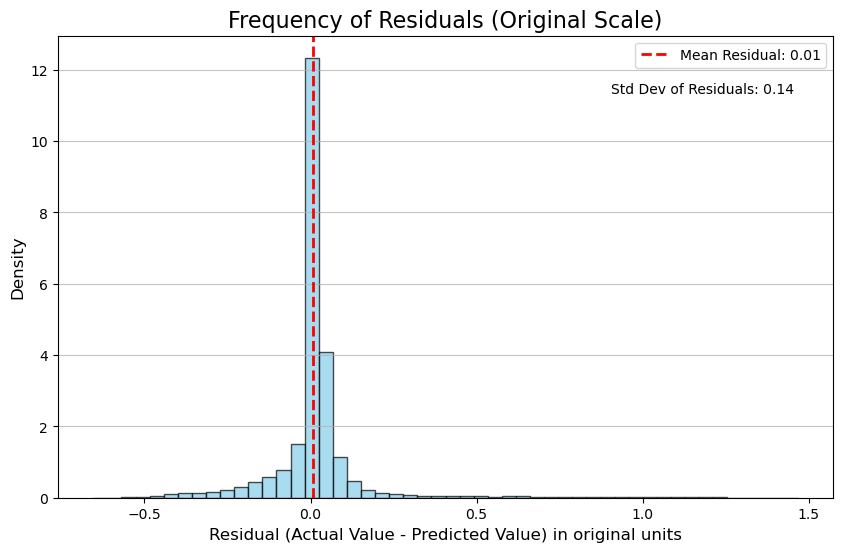

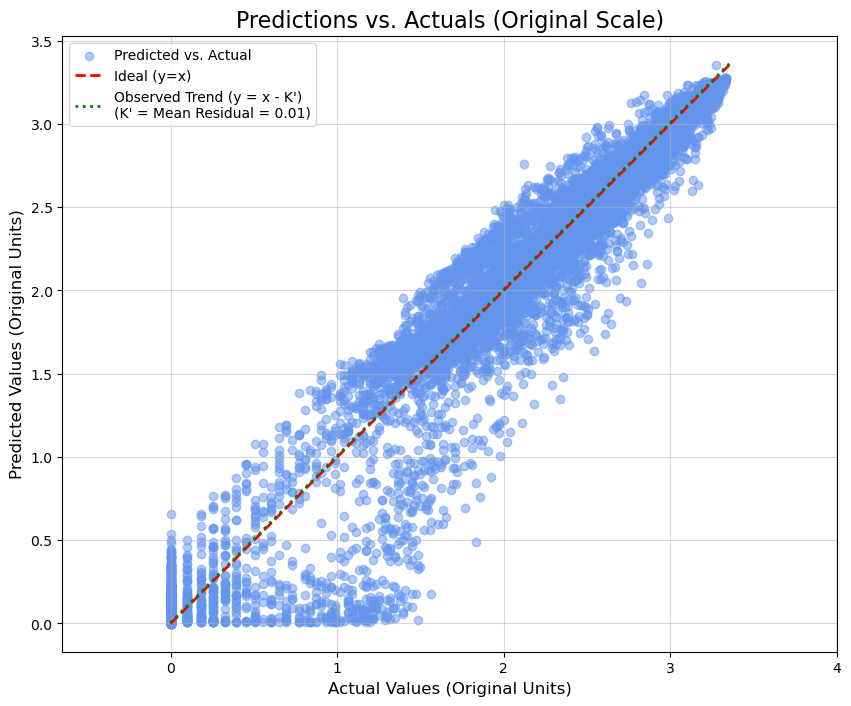

In [14]:
if original_actuals is not None and original_preds is not None:
    logging.info("Generating residual and prediction vs. actual plots for original scale data...")
    
    # Calculate residuals in the original scale
    residuals_original = original_actuals.flatten() - original_preds.flatten()
    mean_residuals_original = np.mean(residuals_original)
    std_residuals_original = np.std(residuals_original)

    # --- 1. Frequency of Residuals (Histogram) in Original Scale ---
    plt.figure(figsize=(10, 6))
    plt.hist(residuals_original, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    plt.axvline(mean_residuals_original, color='red', linestyle='dashed', linewidth=2, 
                label=f'Mean Residual: {mean_residuals_original:.2f}')
    plt.title('Frequency of Residuals (Original Scale)', fontsize=16)
    plt.xlabel(f'Residual (Actual Value - Predicted Value) in original units', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.75)
    plt.text(0.95, 0.90, f'Std Dev of Residuals: {std_residuals_original:.2f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=plt.gca().transAxes, fontsize=10)
    plt.show()

    # --- 2. Predictions vs. Actuals in Original Scale ---
    plt.figure(figsize=(10, 8))
    plt.scatter(original_actuals, original_preds, alpha=0.5, color='cornflowerblue', label='Predicted vs. Actual')
    
    # Determine plot limits for y=x line and observed trend
    min_val = min(np.min(original_actuals), np.min(original_preds))
    max_val = max(np.max(original_actuals), np.max(original_preds))
    
    # Ideal line (y=x)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (y=x)')
    
    # Observed trend line (y = x - K', where K' is mean_residuals_original)
    # This line represents: predicted = actual - mean_residual
    plt.plot([min_val, max_val], 
             [min_val + mean_residuals_original, max_val + mean_residuals_original], 
             # Corrected: if residual = actual - predicted, then predicted = actual - residual.
             # So if K' = actual - predicted, then predicted = actual - K'.
             # The plot should be y (predicted) vs x (actual).
             # If mean_residuals_original > 0, model under-predicts on average, so predicted = actual - |K'|
             # If mean_residuals_original < 0, model over-predicts on average, so predicted = actual + |K'|
             # So, it's always predicted = actual - mean_residuals_original
             'g:', lw=2, 
             label=f'Observed Trend (y = x - K\')\n(K\' = Mean Residual = {mean_residuals_original:.2f})')
             
    plt.title('Predictions vs. Actuals (Original Scale)', fontsize=16)
    plt.xlabel('Actual Values (Original Units)', fontsize=12)
    plt.ylabel('Predicted Values (Original Units)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.5)
    plt.axis('equal') 
    plt.show()

else:
    logging.warning("Could not generate plots because original_actuals or original_preds is None.")

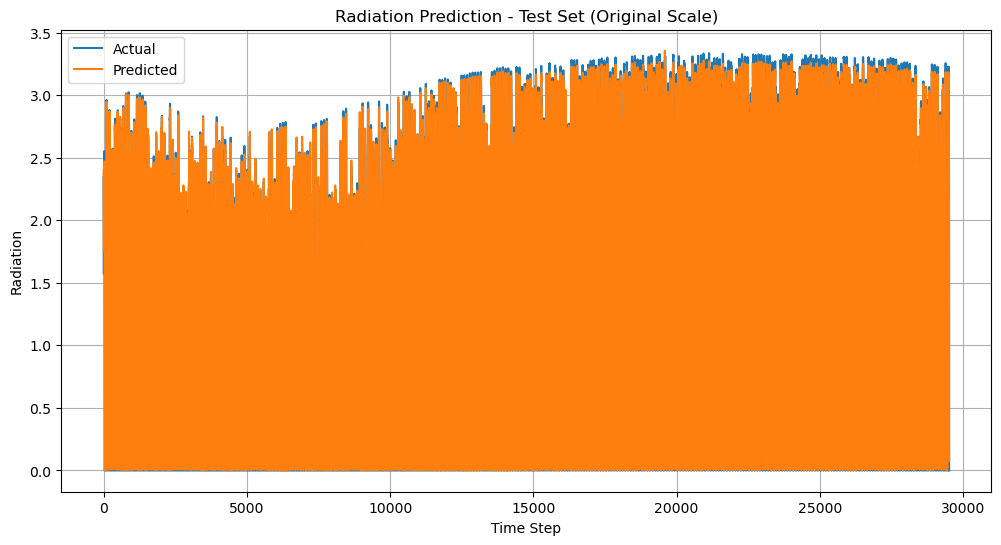

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(original_actuals, label='Actual')
plt.plot(original_preds, label='Predicted')
plt.title('Radiation Prediction - Test Set (Original Scale)')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
df["GHI"].max()

229.2

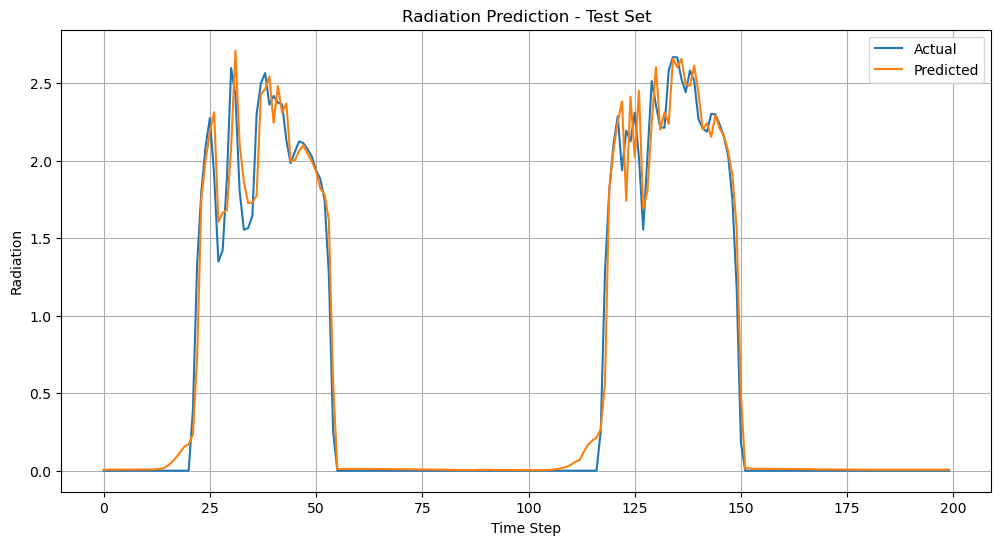

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(original_actuals[2950:3150], label='Actual')
plt.plot(original_preds[2950:3150], label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
pred_with_uncertainty = model.predict_with_uncertainty(X_test[0:100], mc_samples=30,        
        target_scaler=scalers.get(full_transform_details.get('target_scaler_name')), # Get the specific target scaler
        transform_info=full_transform_details, # This should be the output from data_prep
        scalers_dict=scalers,
        device = device)  # Pass the whole scalers dictionary)

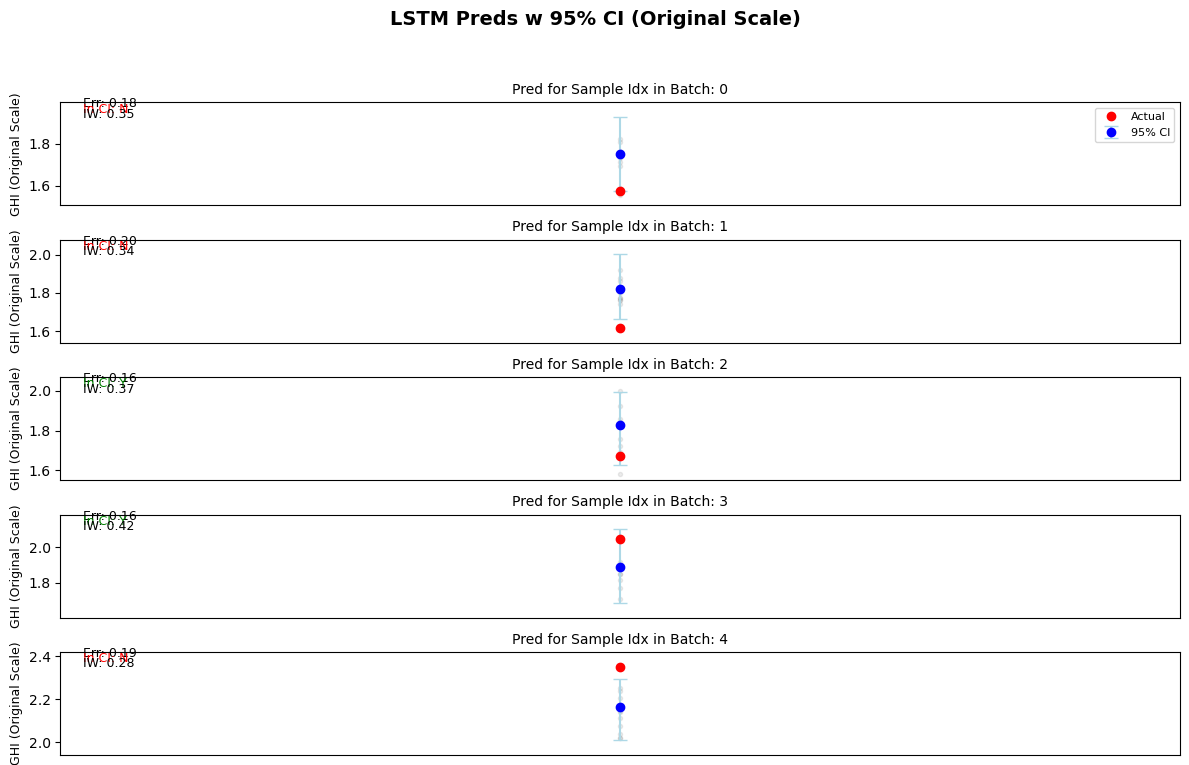

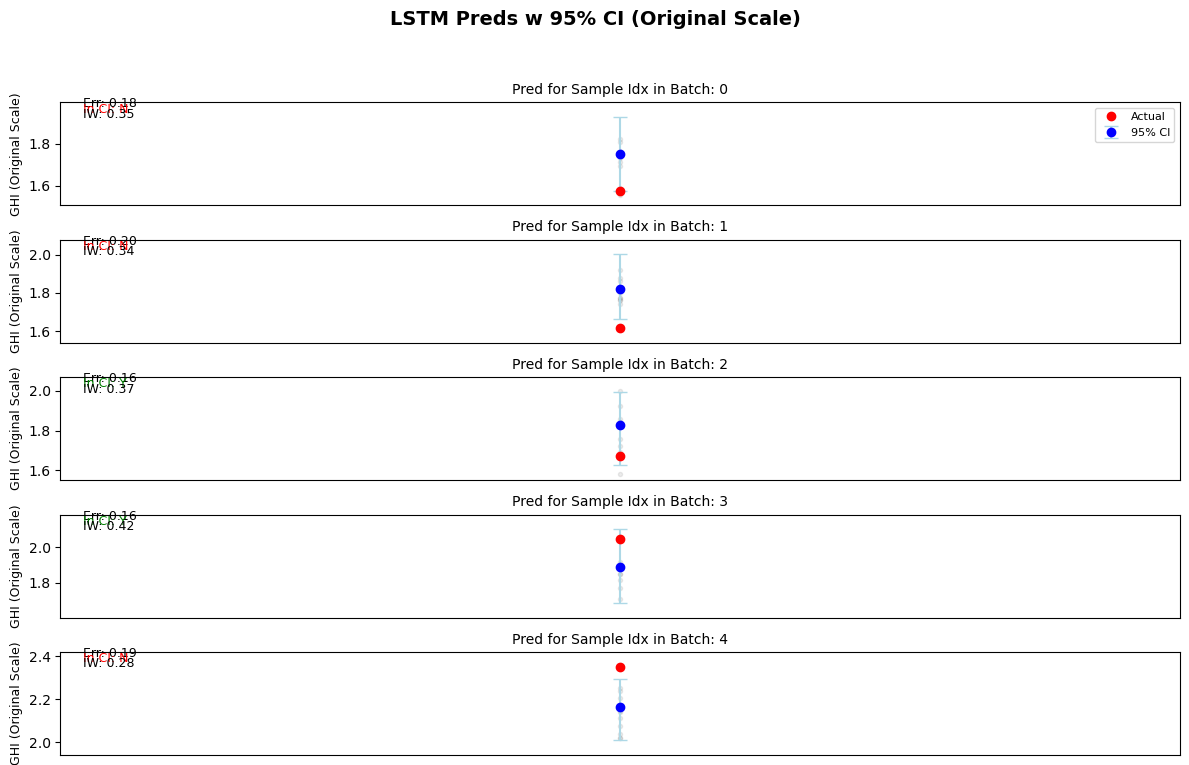

In [23]:
model.plot_prediction_with_uncertainty(X_test[0:100],y_test[0:100],mc_samples=30, 
                                       target_scaler=scalers.get(full_transform_details.get('target_scaler_name')),
                                       transform_info=full_transform_details, # This should be the output from data_prep
                                        scalers_dict=scalers,
                                        device = device,
                                        max_samples_to_plot = 5)


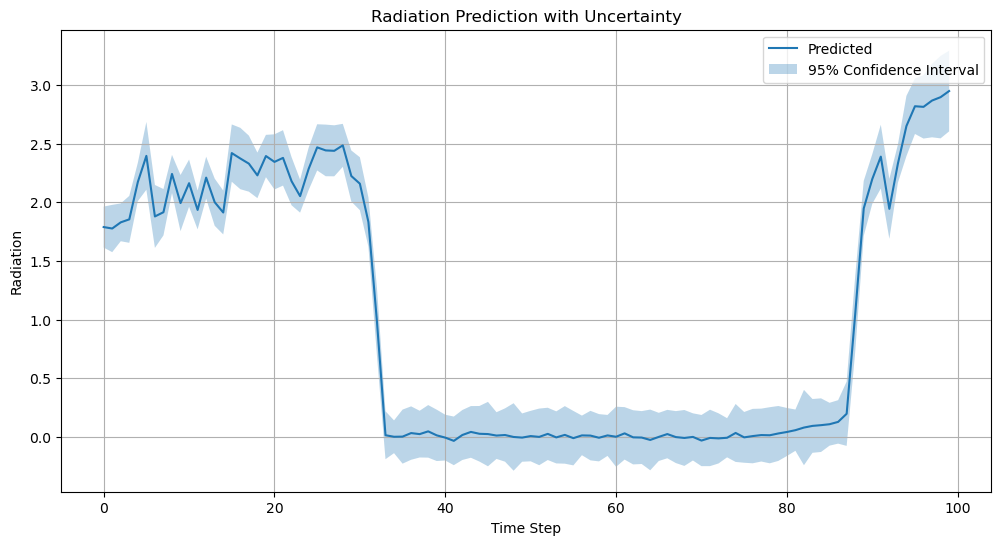

In [22]:
# plot uncertainty
plt.figure(figsize=(12, 6))
plt.plot(pred_with_uncertainty['mean'].squeeze(), label='Predicted')
plt.fill_between(range(len(pred_with_uncertainty['std'])), 
                 (pred_with_uncertainty['mean'] - 1.96 * pred_with_uncertainty['std']).squeeze(),
                 (pred_with_uncertainty['mean'] + 1.96 * pred_with_uncertainty['std']).squeeze(),
                 alpha=0.3, label='95% Confidence Interval')
plt.title('Radiation Prediction with Uncertainty')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
print(model.fc3.bias.item())
print(model.fc3.weight)


0.05188759043812752
Parameter containing:
tensor([[ 0.0440,  0.0779,  0.0657, -0.1508,  0.0867,  0.0483, -0.1137, -0.0989,
         -0.1305, -0.1771, -0.1345, -0.0787, -0.1681,  0.0413,  0.0677,  0.0932,
          0.0642, -0.2249, -0.1253, -0.0663,  0.0851,  0.0687,  0.0626, -0.1275,
         -0.1040,  0.1189, -0.1228,  0.0530, -0.0417, -0.1421, -0.0658, -0.1113,
         -0.0764,  0.0901,  0.0248, -0.0727,  0.0760,  0.0963,  0.0847,  0.0788,
          0.0533, -0.1137,  0.0575,  0.1734,  0.0216,  0.0386, -0.0894, -0.1245,
         -0.1394, -0.1412, -0.0945,  0.0420, -0.1333, -0.0939,  0.0621,  0.1086,
         -0.0506, -0.1381, -0.1390, -0.1117,  0.0327, -0.0649,  0.0585,  0.3722]],
       requires_grad=True)


In [ ]:
model.save('weather_lstm_model.pt')



# Weather Prediction LSTM Model: Technical Summary

## Model Architecture

The model utilizes a Long Short-Term Memory (LSTM) network. The specific structure of the `WeatherLSTM` network, based on the final trained model, is as follows:

**WeatherLSTM Network Structure:**<br>
┌─────────────────────────────────────────────────────┐<br>
│ ➤ LSTM Layer (19→256, layers=1, dropout=0.3)        │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (256→128)                   │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (128→64)                    │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (64→1)                      │<br>
└─────────────────────────────────────────────────────┘

## Core Parameters

  - **Input Dimension**: 19 features
  - **Hidden Dimension**: 256
  - **LSTM Layers**: 1
  - **Output Dimension**: 1 (predicting a single value, 'Radiation')
  - **Dropout Probability**: 0.3 (applied after the LSTM layer and after each ReLU activation in the fully connected block)
  - **Fully Connected Layers**: 256→128→64→1 with ReLU activations

## Dataset Structure

  - **Training Set**: X\_train shape: (118051, 24, 19), y\_train shape: (118051, 1)
  - **Validation Set**: X\_val shape: (49188, 24, 19), y\_val shape: (49188, 1)
  - **Test Set**: X\_test shape: (29513, 24, 19), y\_test shape: (29513, 1)
  - **Data Format**: Sequences of 24 timesteps, with 19 features per timestep.

## Loss Function

The model was trained using the Mean Squared Error (MSE) loss function:

$\\mathcal{L}*{MSE} = \\frac{1}{n}\\sum*{i=1}^{n}(y\_{true} - y\_{pred})^2$

(Note: The Optuna hyperparameter search explored a combined MSE and MAPE loss, but the final model training utilized MSE loss.)

## Regularization Techniques

  - **Dropout**: Probability of 0.3 applied after the LSTM layer and after each ReLU activation in the fully connected block.
  - **L2 Regularization**: Weight decay of $1 \\times 10^{-5}$ applied during training.
  - **Gradient Clipping**: Norm constrained to 1.0 to prevent exploding gradients.

## Optimization Strategy

  - **Optimizer**: Adam.
  - **Learning Rate**: $0.00015$ for the final training.
  - **Learning Rate Scheduler**: CosineAnnealingLR with $T\_{max}=100$.
  - **Patience for Early Stopping**: 30 epochs (though the final training ran for the full 100 epochs as per the log).

## Data Transformation

  - **Target Variable ('Radiation') Transformation**:
      - A floor of 0.0 was applied to 'Radiation' values before transformation.
      - Yeo-Johnson Power Transform applied to the 'Radiation' column (lambda = -0.1973). The transformed target is named 'Radiation\_yeo'.
      - The transformed target ('Radiation\_yeo') was then scaled using StandardScaler.
  - **Feature Scaling**: Input features were scaled using MinMaxScaler.
  - **Feature Engineering**:
      - 'SolarElevation': A proxy feature for solar elevation was added.
      - 'Radiation\_is\_low': A binary feature created with a threshold of 0.0 for the 'Radiation' value.
      - Redundant date/time features were removed if similar ones already existed (e.g., 'DaylightMinutes' removed if 'dayLength' present).

## Input Features

The model uses 19 features for prediction:

  - 'Humidity'
  - 'Pressure'
  - 'Radiation' (original)
  - 'Radiation\_is\_low'
  - 'SolarElevation'
  - 'Speed' (wind speed)
  - 'SunlightTime/daylength' (Daylight Position)
  - 'Temperature'
  - 'TimeMinutesCos' (Cyclical encoding of time)
  - 'TimeMinutesSin' (Cyclical encoding of time)
  - 'clouds\_all'
  - 'dayLength'
  - 'hour'
  - 'isSun' (IsDaylight)
  - 'month'
  - 'rain\_1h'
  - 'snow\_1h'
  - 'sunlightTime'
  - 'weather\_type'

## Key Performance Metrics (Test Set - Original Scale)

  - **RMSE (Root Mean Squared Error)**: 7.8630
  - **MAE (Mean Absolute Error)**: 3.5478
  - **R² (R-squared)**: 0.9791
  - **Correlation Coefficient**: 0.9914
  - **MAPE (Mean Absolute Percentage Error)**: Extremely high due to near-zero actual values.
  - **MAPE (capped at 100% error per point)**: 56.81%

## Error Distribution Analysis

The residuals (Actuals - Predictions) on the scaled test data show:

  - **Mean Residual**: 0.0028
  - **Std Dev of Residuals**: 0.0275
  - **Min/Max Residuals**: -0.1730 / 0.2808

The high uncapped MAPE on the original scale suggests the model may struggle with predictions when true radiation values are very close to zero. However, the R² value close to 1 and high correlation indicate a strong overall fit for the majority of the data points. The capped MAPE provides a more stable metric for percentage error in such cases.

This architecture, combined with the data preprocessing and regularization techniques, aims to capture the complex temporal patterns in weather data for accurate radiation prediction, demonstrating strong performance as indicated by the R² and correlation metrics.
